In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import auc, roc_curve, classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
import import_ipynb


#Task 2
Реализуйте в отдельном модуле(!) K-Nearest Neighbors, Naive Bayes, Decision Tree Classifier. Протестируйте их работу на своих данных в нотбуке. Сравните с результатами из sklearn. При реализации не допускается использование сторонних модулей (за исключением numpy).

In [ ]:
water_dataframe = pd.read_csv('water_potability.csv')
water_dataframe = water_dataframe.dropna()

In [ ]:
water_dataframe = water_dataframe.sample(frac=1)
water_dataframe.head(5)

ph    Hardness        Solids  Chloramines     Sulfate  \
3043  6.260892  188.061805  33809.224701     8.141301  341.498044   
755   9.888941  220.638823  19892.388914     7.986456  326.076560   
2134  5.632041  203.730481  19345.922475     8.047798  265.347111   
799   9.393148  215.051365  20592.258942    10.089537  331.338739   
1513  6.353437  218.549363  18664.844297     6.690394  312.393019   

      Conductivity  Organic_carbon  Trihalomethanes  Turbidity  Potability  
3043    522.301232       14.467501        47.050155   4.397386           0  
755     460.812425       14.929172        59.602808   3.750164           1  
2134    708.226364       15.752252        69.195926   3.511985           0  
799     447.074460       10.778633        54.426968   4.665681           1  
1513    503.414897       15.422459        94.386932   3.861109           1

##Очистка данных от аномалий

In [ ]:
water_dataframe.describe() #так как все признаки в датафрейме вещественные, то для "детекта" выбросов достаточно использовать функцию 
#describe(). Видно, что выбросы есть практически у каждого признака(максимальное значение превышает третий квартиль на большие величины, либо
#минимальное значение сильно меньше первого квартиля)

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2011.000000  2011.000000   2011.000000  2011.000000  2011.000000   
mean      7.085990   195.968072  21917.441374     7.134338   333.224672   
std       1.573337    32.635085   8642.239815     1.584820    41.205172   
min       0.227499    73.492234    320.942611     1.390871   129.000000   
25%       6.089723   176.744938  15615.665390     6.138895   307.632511   
50%       7.027297   197.191839  20933.512750     7.143907   332.232177   
75%       8.052969   216.441070  27182.587067     8.109726   359.330555   
max      14.000000   317.338124  56488.672413    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   2011.000000     2011.000000      2011.000000  2011.000000  2011.000000  
mean     426.526409       14.357709        66.400859     3.969729     0.403282  
std       80.712572        3.324959        16.077109     0.780346     0.490678  
min      201.619737        2.200000         8.577013     1.450000     0.000000  
25%      366.680307       12.124105        55.952664     3.442915     0.000000  
50%      423.455906       14.322019        66.542198     3.968177     0.000000  
75%      482.373169       16.683049        77.291925     4.514175     1.000000  
max      753.342620       27.006707       124.000000     6.494749     1.000000

In [ ]:
Q_1 = {} #объявляем словари для минимального и максимального значения
Q_3 = {}
for elem in water_dataframe.describe().drop(columns=['Potability']).columns:
  Q_1[elem] = water_dataframe.describe().iloc[4][elem] #записываем в словарь значения первого квартиля
  Q_3[elem] = water_dataframe.describe().iloc[6][elem] #записываем в словарь значения третьего квартиля

In [ ]:
for elem in water_dataframe.describe().drop(columns=['Potability']).columns:
  water_dataframe = water_dataframe[water_dataframe[elem] < (Q_3[elem] + (0.439 * Q_3[elem]))]
  water_dataframe = water_dataframe[water_dataframe[elem] > (Q_1[elem] - (0.495 * Q_1[elem]))]
  #print(water_dataframe.loc[i][elem])

In [ ]:
water_dataframe.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  1784.000000  1784.000000   1784.000000  1784.000000  1784.000000   
mean      7.098621   195.581447  21305.953265     7.144715   334.037324   
std       1.476457    31.566892   7185.204836     1.459044    39.288872   
min       3.148712    94.091307   7907.330441     3.117441   187.424131   
25%       6.110177   176.921378  15715.740730     6.185942   309.230458   
50%       7.034491   197.076345  20473.847706     7.138343   333.044572   
75%       8.029650   215.431708  26476.413758     8.083132   359.141540   
max      11.563169   306.627481  39030.603705    11.543190   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   1784.000000     1784.000000      1784.000000  1784.000000  1784.000000  
mean     427.210807       14.472336        66.640356     3.985440     0.395179  
std       80.423657        3.183521        15.418630     0.778080     0.489026  
min      201.619737        6.124625        28.566364     1.812529     0.000000  
25%      367.927117       12.256113        56.281209     3.449837     0.000000  
50%      423.850390       14.384537        66.583401     3.979666     0.000000  
75%      484.095410       16.801797        77.371974     4.531610     1.000000  
max      669.725086       23.917601       111.115310     6.494749     1.000000

##Разбиение выборки на обучающую и тестовую

In [ ]:
Loss = ({'model' : [], 'test_accuracy' : [], 'test_recall' :[] , 'test_auc' :[]}) #Заводим пустой датафрейм для метрик качества
df_Loss = pd.DataFrame(Loss)

In [ ]:
#Разбиваем выборку на обучающую тестовую
X = water_dataframe.drop(columns=['Potability'])
y = water_dataframe['Potability']
(X_train, X_test, 
y_train, y_test) = train_test_split(X, y, 
                                     test_size=0.3, 
                                     random_state=water_dataframe.shape[0], stratify = y)

In [ ]:
#Масштабируем признаки 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def loss_func(df, model, y_test, y_pred):  # функция для оценки качества обученной модели
  te_ac = accuracy_score(y_test, y_pred).round(4)
  te_rec = recall_score(y_test, y_pred).round(4)
  te_auc = roc_auc_score(y_test, y_pred).round(4)
  new_row = {'model' : model, 'test_accuracy' : te_ac, 'test_recall' : te_rec, 'test_auc' : te_auc}
  df = df.append(new_row, ignore_index = True)
  return df

##Метод ближайших соседей, нативная реализация

In [ ]:
def euclidian_metric(x, y):
    return np.sqrt(np.sum((x - y)**2))

In [ ]:
def Native_KNN(X_train, X_test, y_train, k_neighbors):
  y_pred_knn = []
  y_train = np.array(y_train)
  for test_value in X_test: 
    min_metric = []
    for i in range(len(X_train)):
      min_metric.append((euclidian_metric(test_value, X_train[i]), y_train[i]))
    m = sorted(min_metric)[:k_neighbors]
    first_class = 0
    second_class = 0
    for i in range(len(m)):
      if m[i][1] == 1:
        first_class += 1
        continue
      second_class += 1
    if first_class > second_class:
      y_pred_knn.append(1)
      continue
    y_pred_knn.append(0)
  return y_pred_knn

In [ ]:
y_pred_knn_native = Native_KNN(X_train, X_test, y_train, 23)
loss_func(df_Loss, "Native KNN", y_test, y_pred_knn_native)

model  test_accuracy  test_recall  test_auc
0  Native KNN         0.6604       0.2689    0.5928

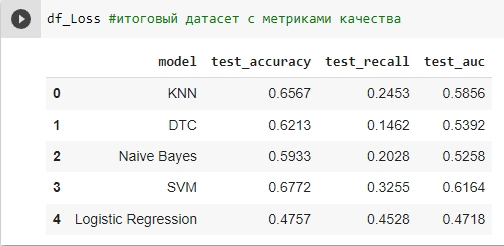

In [ ]:
from IPython.display import Image #модель, реализованная вручную при тех же гиперпараметрах показывает немного более лучшие результаты
Image('res_sklearn.jpg')

#Нативная реализация Naive Bayes
Наивный байесовский классификатор предполагает, что наличие функции в классе не связано с какой-либо другой функцией. Даже если эти признаки зависят друг от друга или от наличия других признаков, все эти свойства независимо способствуют вероятности того, что конкретный фрукт является яблоком, апельсином или бананом, и именно поэтому он известен как «Наивный». «.

In [ ]:
means = X_train.groupby(y_train).apply(np.mean)
standards = X_train.groupby(y_train).apply(np.std)
 
# Вычисляем априорную вероятность класса
probability = X_train.groupby(y_train).apply(lambda x: len(x)) / X_train.shape[0]
y_pred_NB = [] # заводим лист для предсказаний
# каждый элемент в тестовой части данных
for elem in range(X_test.shape[0]):
   dict_probability = {}
   # для каждого возможного класса
   for classes in np.unique(y_train):
       # априорная вероятность взятого ранее класса
       dict_probability[classes] = probability.iloc[classes]
       # для каждого столбца в датасете
       for index, parametres in enumerate(X_test.iloc[elem]):
           # умножаем вероятность того, что данное значение столбца
           # будет принадлежать распределению для выбранного класса
           dict_probability[classes] *= np.exp((-((parametres - means.iloc[classes, index])/standards.iloc[classes, index])**2)/2)/((2*3.1416)**0.5) # плотность вероятности для нормы
   y_pred_NB.append(pd.Series(dict_probability).values.argmax())
loss_func(df_Loss, "Naive Bayes", y_test, y_pred_NB)

model  test_accuracy  test_recall  test_auc
0  Naive Bayes         0.6269       0.3066    0.5715

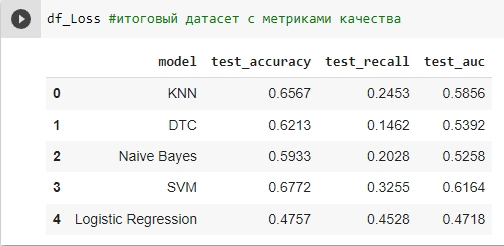

In [ ]:
Image('res_sklearn.jpg')

#Нативная реализация Decision Tree Classifier

#Визуализация результатов

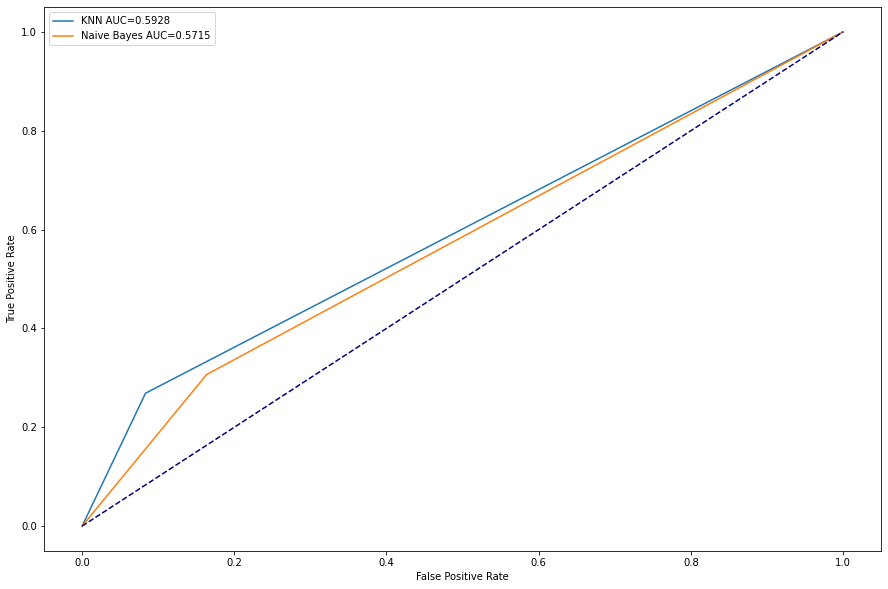

In [ ]:

plt.figure(figsize = (15,10))
models = ['KNN', 'Naive Bayes']
y_native = []
y_native.append(y_pred_knn_native)
y_native.append(y_pred_NB)

for n in range(len(y_native)):
    fpr, tpr, _ = roc_curve(y_test, y_native[n])
    auc = roc_auc_score(y_test, y_native[n])
    lw = 1.5
    plt.plot(fpr,tpr,label=str(models[n])+" AUC="+str(auc.round(4)),lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=0)
plt.show()